<a href="https://colab.research.google.com/github/suzzini/DS_Study/blob/main/coronadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

한글 깨짐 문제 해결

In [1]:
#해당 셀 실행 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,562 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#설정 변환을 위해서 matplotlib만 import
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

# MacOS
#mpl.rc("font", family='AppleGothic')

In [3]:
import requests 
import pandas as pd 
from bs4 import BeautifulSoup 
from datetime import date, datetime 

def getCovid19Info(start_date: date, end_date: date): 
  url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19GenAgeCaseInfJson" 
  api_key_utf8 = "zMLNeBeTjLWViEmY%2BV3xqMuqCJVhZ0%2Fv5%2FESR5vFzH%2FQoRNdsotDqTRLcx2Qg10OoS6MseNTQxuIEfKb5lVo1Q%3D%3D" 
  api_key_decode = requests.utils.unquote(api_key_utf8, encoding='utf-8')
  
  params={ "ServiceKey": api_key_decode, 
          "startCreateDt": int('{:04d}{:02d}{:02d}'.format(start_date.year, start_date.month, start_date.day)), 
          "endCreateDt": int('{:04d}{:02d}{:02d}'.format(end_date.year, end_date.month, end_date.day)), 
          } 
          
  response = requests.get(url, params=params) 
  
  return BeautifulSoup(response.text, "lxml")

In [4]:
convert_method = { 
    'confcase':int,
    'confcaserate':float,
    'criticalrate':float,
    'deathrate':float,
    'seq':int,
    'gubun': str, 
    'death': int, 
    'createdt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'), #(x, '%Y-%m-%d %H:%M:%S.%f'), 
    'updatedt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') }

In [5]:
def parsing(items):
  item_list = [] 

  for item in items: 
    item_dict = {} 
    for tag in list(item): 
      try: 
        item_dict[tag.name] = convert_method[tag.name](tag.text) 
      except Exception: 
        item_dict[tag.name] = None 
    item_list.append(item_dict) 
    
  df = pd.DataFrame(item_list)
  return df

### 1. 성별,연령별 

In [134]:
#가져오고 싶은 날짜 지정하여 데이터 가져오기
temp = getCovid19Info(date(2020,12,31), date(2021, 7, 16)) 
items = temp.find('items') 
df=parsing(items)

In [135]:
#필요한 열만 추출
df=df[['confcase','createdt','death','deathrate','gubun']]
df['createdt']=df['createdt'].dt.strftime('%Y-%m-%d')

In [136]:
#성별 비율은 거의 비슷해서 제외
df=df[~(df['gubun']=='여성') & ~(df['gubun']=='남성')]
df=df.reset_index()
df=df.iloc[:,1:]

In [137]:
#gubun이 총 9씩 있는지 확인하기
check9=pd.DataFrame(df.groupby('createdt').count()['gubun'])
check9=check9.reset_index()
check9[check9['gubun']!=9]

,createdt,gubun
65,2021-03-06,17
117,2021-04-27,8
166,2021-06-15,8


누적 확진자의 수치를 계산하여 결측치 채우기(코로나 라이브 참고)

In [138]:
## 원하는 위치에 넣기
new_data = {
    'confcase' : 22697,
    'createdt' : '2021-06-15',
    'death' : 0,
    'deathrate':0,
    'gubun':'40-49'
}

idx = 220 ## 원하는 인덱스
 
temp1 = df[df.index < idx]
temp2 = df[df.index >= idx]
df = temp1.append(new_data,ignore_index=True).append(temp2, ignore_index=True)

In [139]:
## 원하는 위치에 넣기2
new_data = {
    'confcase' : 16114,
    'createdt' : '2021-04-27',
    'death' : 0,
    'deathrate':0,
    'gubun':'30-39'
}

idx = 659 ## 원하는 인덱스
 
temp1 = df[df.index < idx]
temp2 = df[df.index >= idx]
df = temp1.append(new_data,ignore_index=True).append(temp2, ignore_index=True)

In [140]:
df[(df['createdt']=='2021-03-06')]

,confcase,createdt,death,deathrate,gubun
954,3775,2021-03-06,0,0.00,0-9
955,6229,2021-03-06,0,0.00,10-19
956,13903,2021-03-06,1,0.06,20-29
957,12094,2021-03-06,6,0.37,30-39
958,13245,2021-03-06,14,0.86,40-49
959,17095,2021-03-06,54,3.31,50-59
960,14329,2021-03-06,186,11.40,60-69
961,6935,2021-03-06,450,27.57,70-79
962,4447,2021-03-06,921,56.43,80 이상
1206,3775,2021-03-06,0,0.00,0-9


2021-03-06의 경우 데이터가 중복되어있음을 확인
필요없는 행은 제거 해주기로 함.

In [141]:
df=df.drop([1206,1207,1208,1209,1210,1211,1212,1213])
df=df.reset_index()
df=df.drop('index',axis=1)

날짜, gubun 순으로 정렬하기
  - 정렬을 위해 다음과 같이 replace 함.

In [142]:
df=df.replace('0-9', 'a.0-9')
df=df.replace('10-19', 'b.10-19')
df=df.replace('20-29', 'c.20-29')
df=df.replace('30-39', 'd.30-39')
df=df.replace('40-49', 'e.40-49')
df=df.replace('50-59', 'f.50-59')
df=df.replace('60-69', 'g.60-69')
df=df.replace('70-79', 'h.70-79')
df=df.replace('80 이상', 'i.80 이상')

In [143]:
df=df.sort_values(by=['createdt','gubun'], axis=0)
df=df.reset_index()
df=df.drop('index',axis=1)
df

,confcase,createdt,death,deathrate,gubun
0,2091,2020-12-31,0,0.00,a.0-9
1,3770,2020-12-31,0,0.00,b.10-19
2,9705,2020-12-31,0,0.00,c.20-29
3,7728,2020-12-31,3,0.33,d.30-39
4,8624,2020-12-31,7,0.78,e.40-49
...,...,...,...,...,...
1777,27509,2021-07-16,16,0.78,e.40-49
1778,31725,2021-07-16,75,3.66,f.50-59
1779,24074,2021-07-16,251,12.24,g.60-69
1780,10575,2021-07-16,584,28.47,h.70-79


### 연령별 일일 확진자 구하기

In [144]:
forday=df['confcase'].reset_index()['confcase']
forday.index=forday.index+9

In [145]:
df['ofday']=forday
df['ofday']=df['ofday'].fillna(0)

In [146]:
df['realofday']=df['confcase']-df['ofday']
df[:20]

,confcase,createdt,death,deathrate,gubun,ofday,realofday
0,2091,2020-12-31,0,0.00,a.0-9,0.0,2091.0
1,3770,2020-12-31,0,0.00,b.10-19,0.0,3770.0
2,9705,2020-12-31,0,0.00,c.20-29,0.0,9705.0
3,7728,2020-12-31,3,0.33,d.30-39,0.0,7728.0
4,8624,2020-12-31,7,0.78,e.40-49,0.0,8624.0
5,11398,2020-12-31,30,3.33,f.50-59,0.0,11398.0
6,9632,2020-12-31,106,11.78,g.60-69,0.0,9632.0
7,4769,2020-12-31,258,28.67,h.70-79,0.0,4769.0
8,3023,2020-12-31,496,55.11,i.80 이상,0.0,3023.0
9,2132,2021-01-01,0,0.00,a.0-9,2091.0,41.0


In [147]:
realreal=df['realofday'][9:]
realreal.index=realreal.index-9
realreal

0        41.0
1        74.0
2       131.0
3       145.0
4       154.0
        ...  
1768    268.0
1769    242.0
1770    109.0
1771     14.0
1772      8.0
Name: realofday, Length: 1773, dtype: float64

In [148]:
df['realreal']=realreal
df

,confcase,createdt,death,deathrate,gubun,ofday,realofday,realreal
0,2091,2020-12-31,0,0.00,a.0-9,0.0,2091.0,41.0
1,3770,2020-12-31,0,0.00,b.10-19,0.0,3770.0,74.0
2,9705,2020-12-31,0,0.00,c.20-29,0.0,9705.0,131.0
3,7728,2020-12-31,3,0.33,d.30-39,0.0,7728.0,145.0
4,8624,2020-12-31,7,0.78,e.40-49,0.0,8624.0,154.0
...,...,...,...,...,...,...,...,...
1777,27509,2021-07-16,16,0.78,e.40-49,27241.0,268.0,NaN
1778,31725,2021-07-16,75,3.66,f.50-59,31483.0,242.0,NaN
1779,24074,2021-07-16,251,12.24,g.60-69,23965.0,109.0,NaN
1780,10575,2021-07-16,584,28.47,h.70-79,10561.0,14.0,NaN


In [149]:
#2021-01-01 이후 행만 추출
df=df[(df['createdt']>='2021-01-01') & (df['createdt']<='2021-07-15')]
df

,confcase,createdt,death,deathrate,gubun,ofday,realofday,realreal
9,2132,2021-01-01,0,0.00,a.0-9,2091.0,41.0,39.0
10,3844,2021-01-01,0,0.00,b.10-19,3770.0,74.0,66.0
11,9836,2021-01-01,0,0.00,c.20-29,9705.0,131.0,111.0
12,7873,2021-01-01,4,0.44,d.30-39,7728.0,145.0,109.0
13,8778,2021-01-01,7,0.76,e.40-49,8624.0,154.0,106.0
...,...,...,...,...,...,...,...,...
1768,27241,2021-07-15,15,0.73,e.40-49,26949.0,292.0,268.0
1769,31483,2021-07-15,75,3.66,f.50-59,31244.0,239.0,242.0
1770,23965,2021-07-15,251,12.24,g.60-69,23876.0,89.0,109.0
1771,10561,2021-07-15,584,28.49,h.70-79,10542.0,19.0,14.0


전처리 완료.

In [150]:
df=df[['confcase','createdt','gubun','realreal']]
df=df.reset_index()

In [151]:
df=df.drop('index',axis=1)
df

,confcase,createdt,gubun,realreal
0,2132,2021-01-01,a.0-9,39.0
1,3844,2021-01-01,b.10-19,66.0
2,9836,2021-01-01,c.20-29,111.0
3,7873,2021-01-01,d.30-39,109.0
4,8778,2021-01-01,e.40-49,106.0
...,...,...,...,...
1759,27241,2021-07-15,e.40-49,268.0
1760,31483,2021-07-15,f.50-59,242.0
1761,23965,2021-07-15,g.60-69,109.0
1762,10561,2021-07-15,h.70-79,14.0


1) 연령 구분 없이 하루 확진자 수 구하기

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
foraccumulate=df.groupby('createdt').sum()['confcase']
foraccumulate=foraccumulate.reset_index()

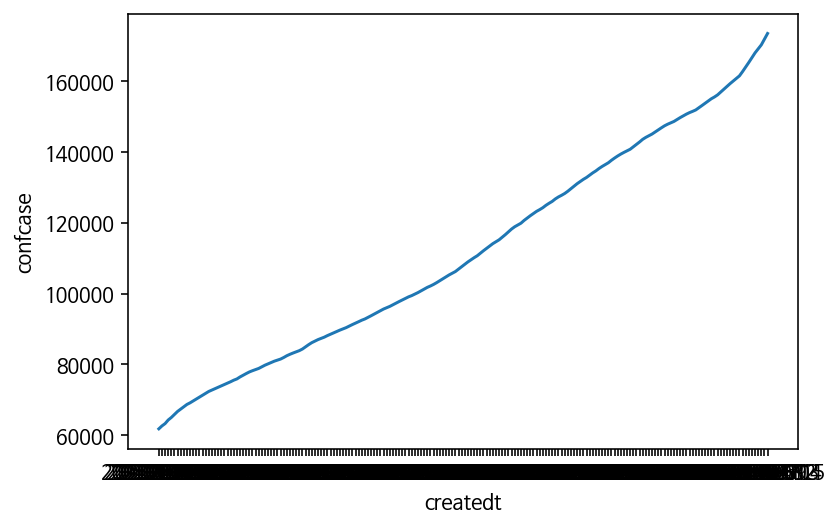

In [154]:
sns.lineplot(data=foraccumulate,x='createdt',y='confcase')

In [155]:
final_forday=pd.DataFrame(df.groupby('createdt').sum()['realreal'])
final_forday=final_forday.reset_index()

In [156]:
final_forday

,createdt,realreal
0,2021-01-01,824.0
1,2021-01-02,651.0
2,2021-01-03,1020.0
3,2021-01-04,715.0
4,2021-01-05,839.0
...,...,...
191,2021-07-11,1100.0
192,2021-07-12,1150.0
193,2021-07-13,1615.0
194,2021-07-14,1600.0


In [157]:
final_forday['createdt']=final_forday['createdt'].str[5:].str.replace('-','/')
final_forday=final_forday.rename(columns={'createdt':'월','realreal':'일일확진자'})

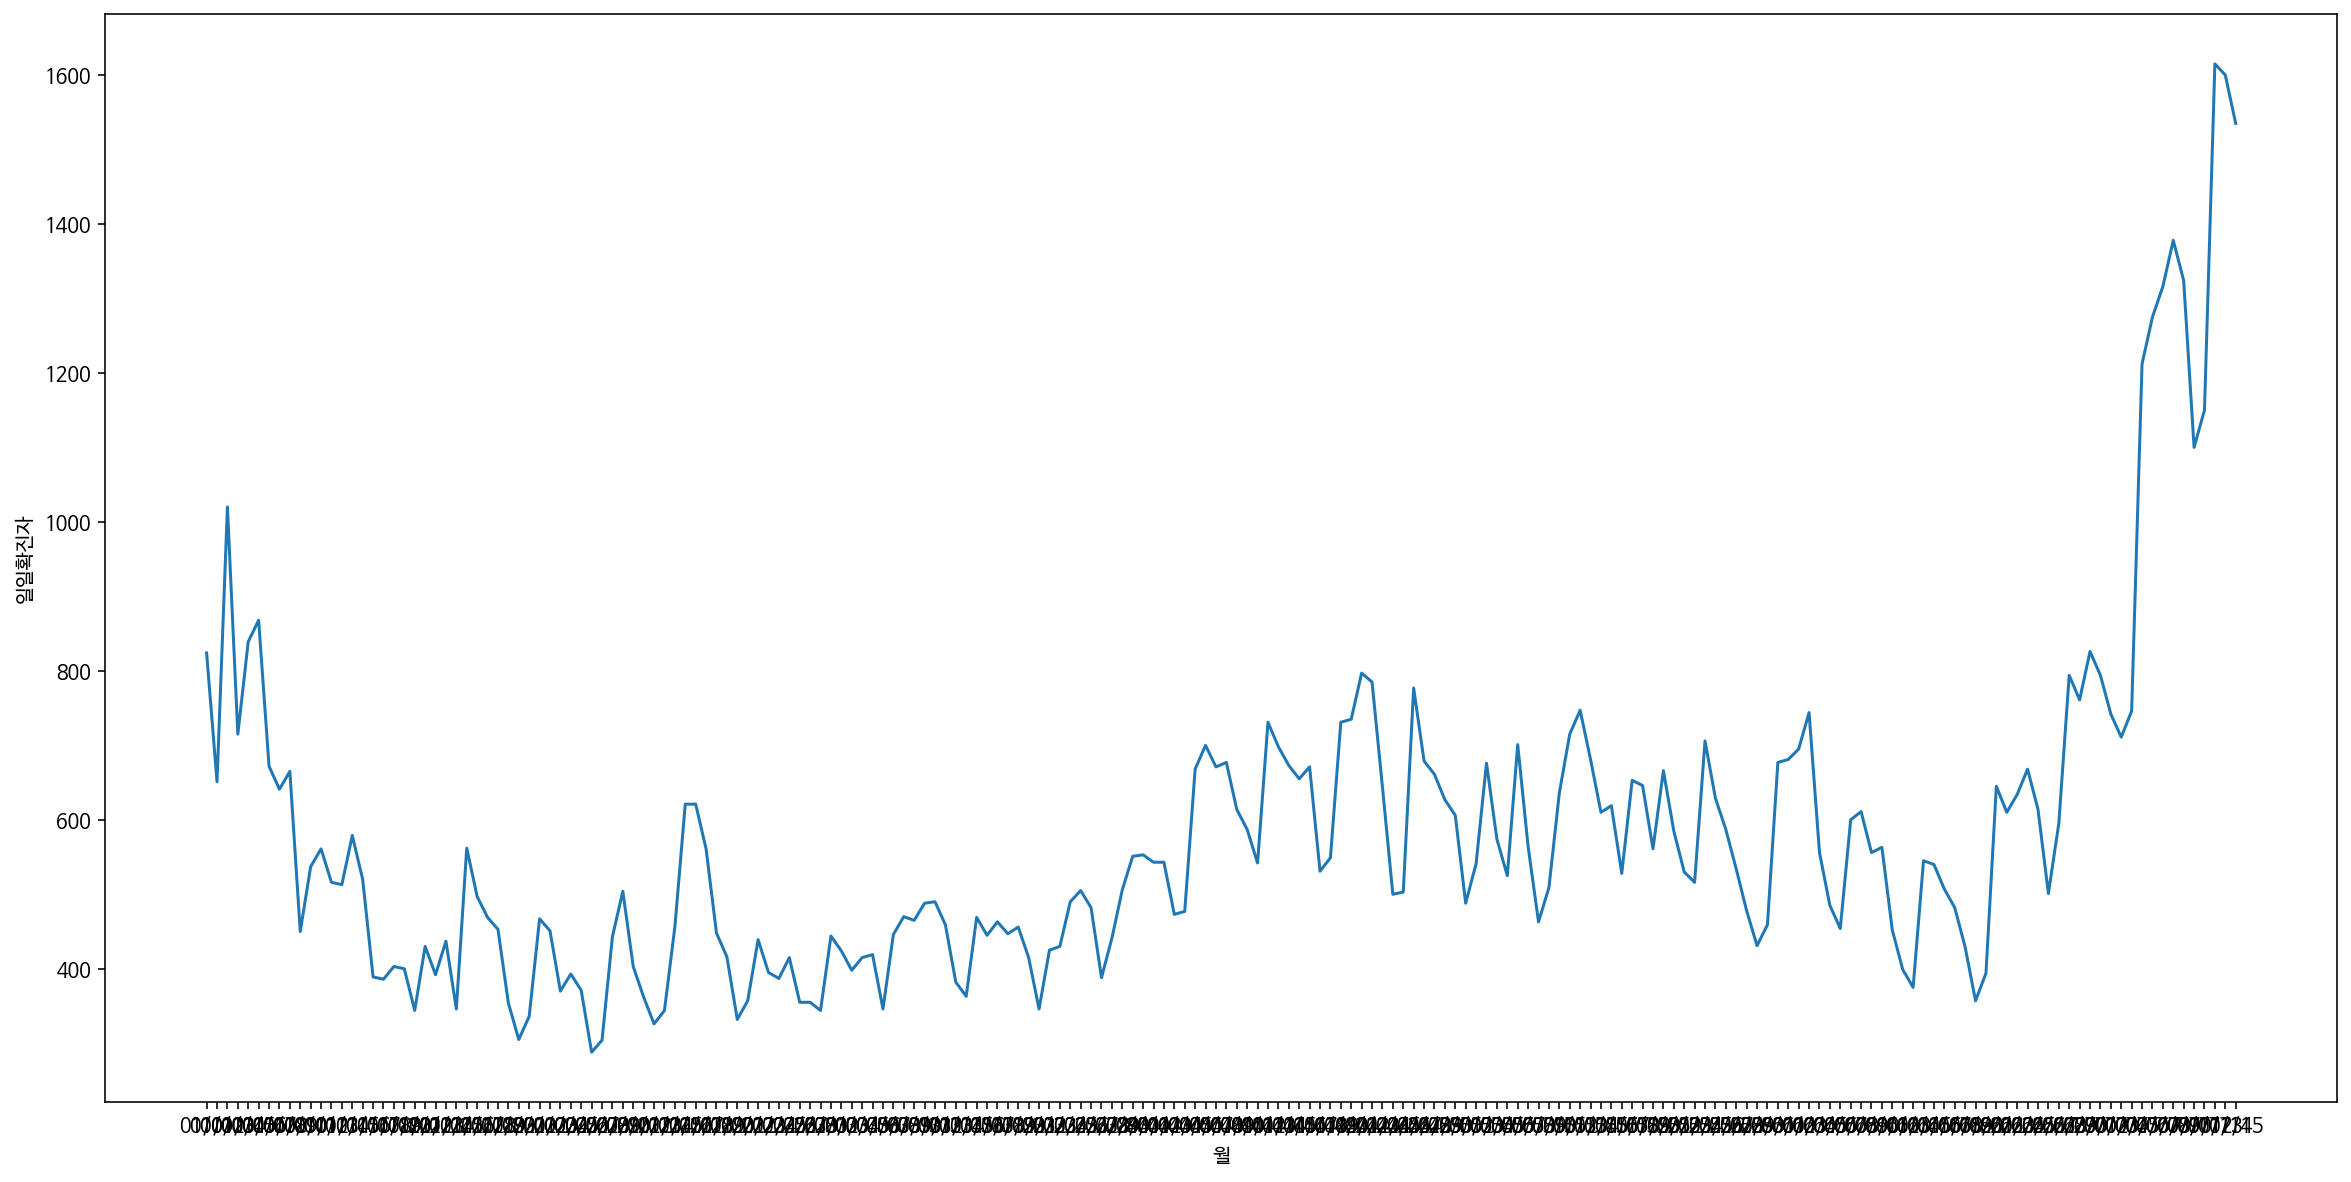

In [158]:
plt.figure(figsize=(20,10))
sns.lineplot(data=final_forday,x='월',y='일일확진자')

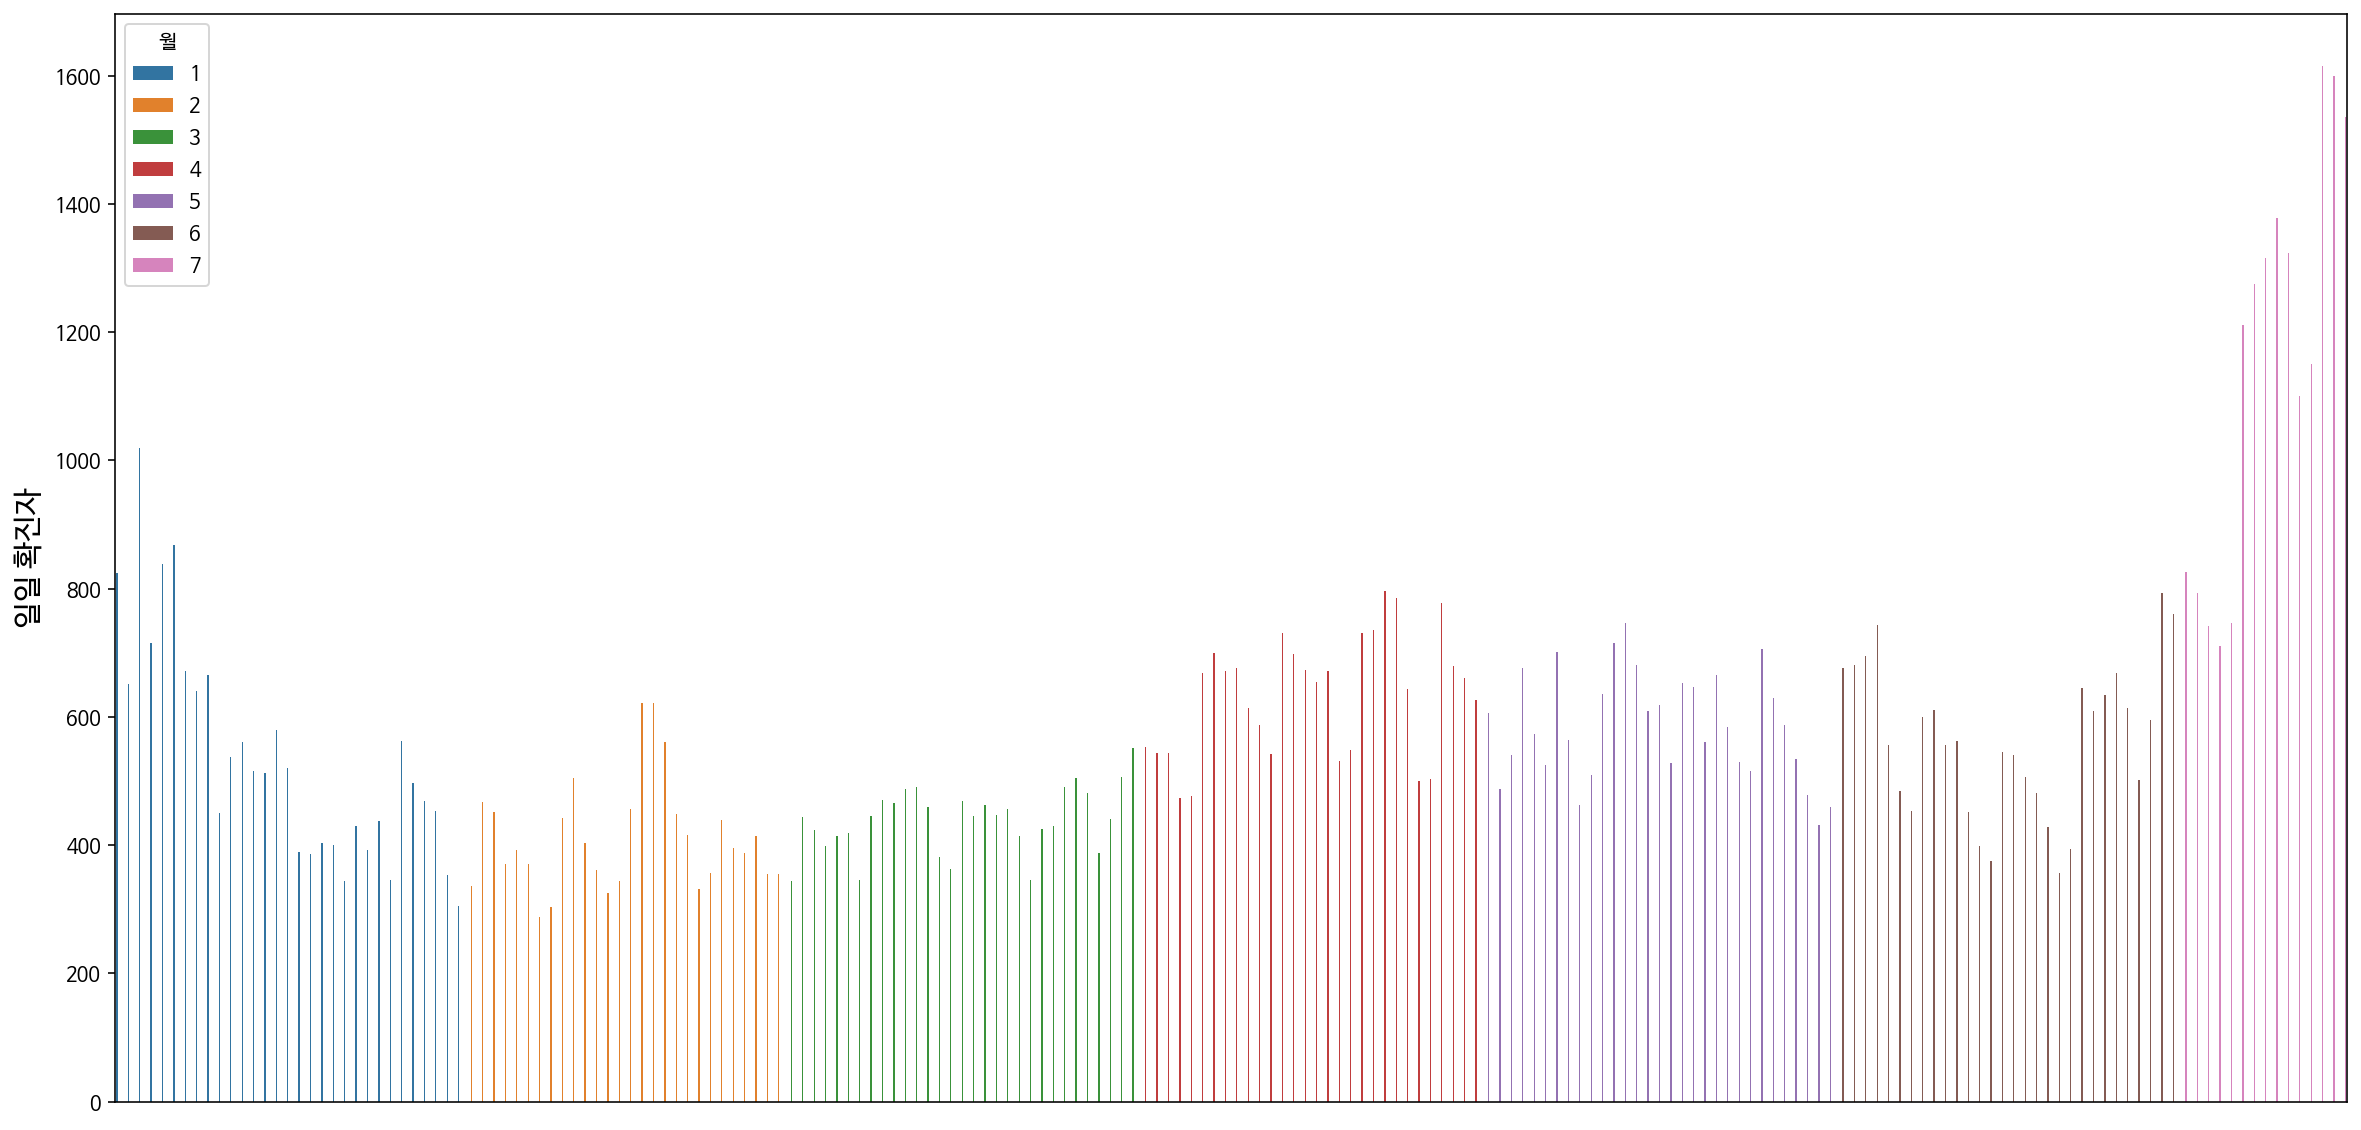

In [159]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
p=sns.barplot(data=final_forday,x='월',y='일일확진자',hue=final_forday['월'].str[1:2])

p.set_ylabel("일일 확진자", fontsize = 15)
plt.show()

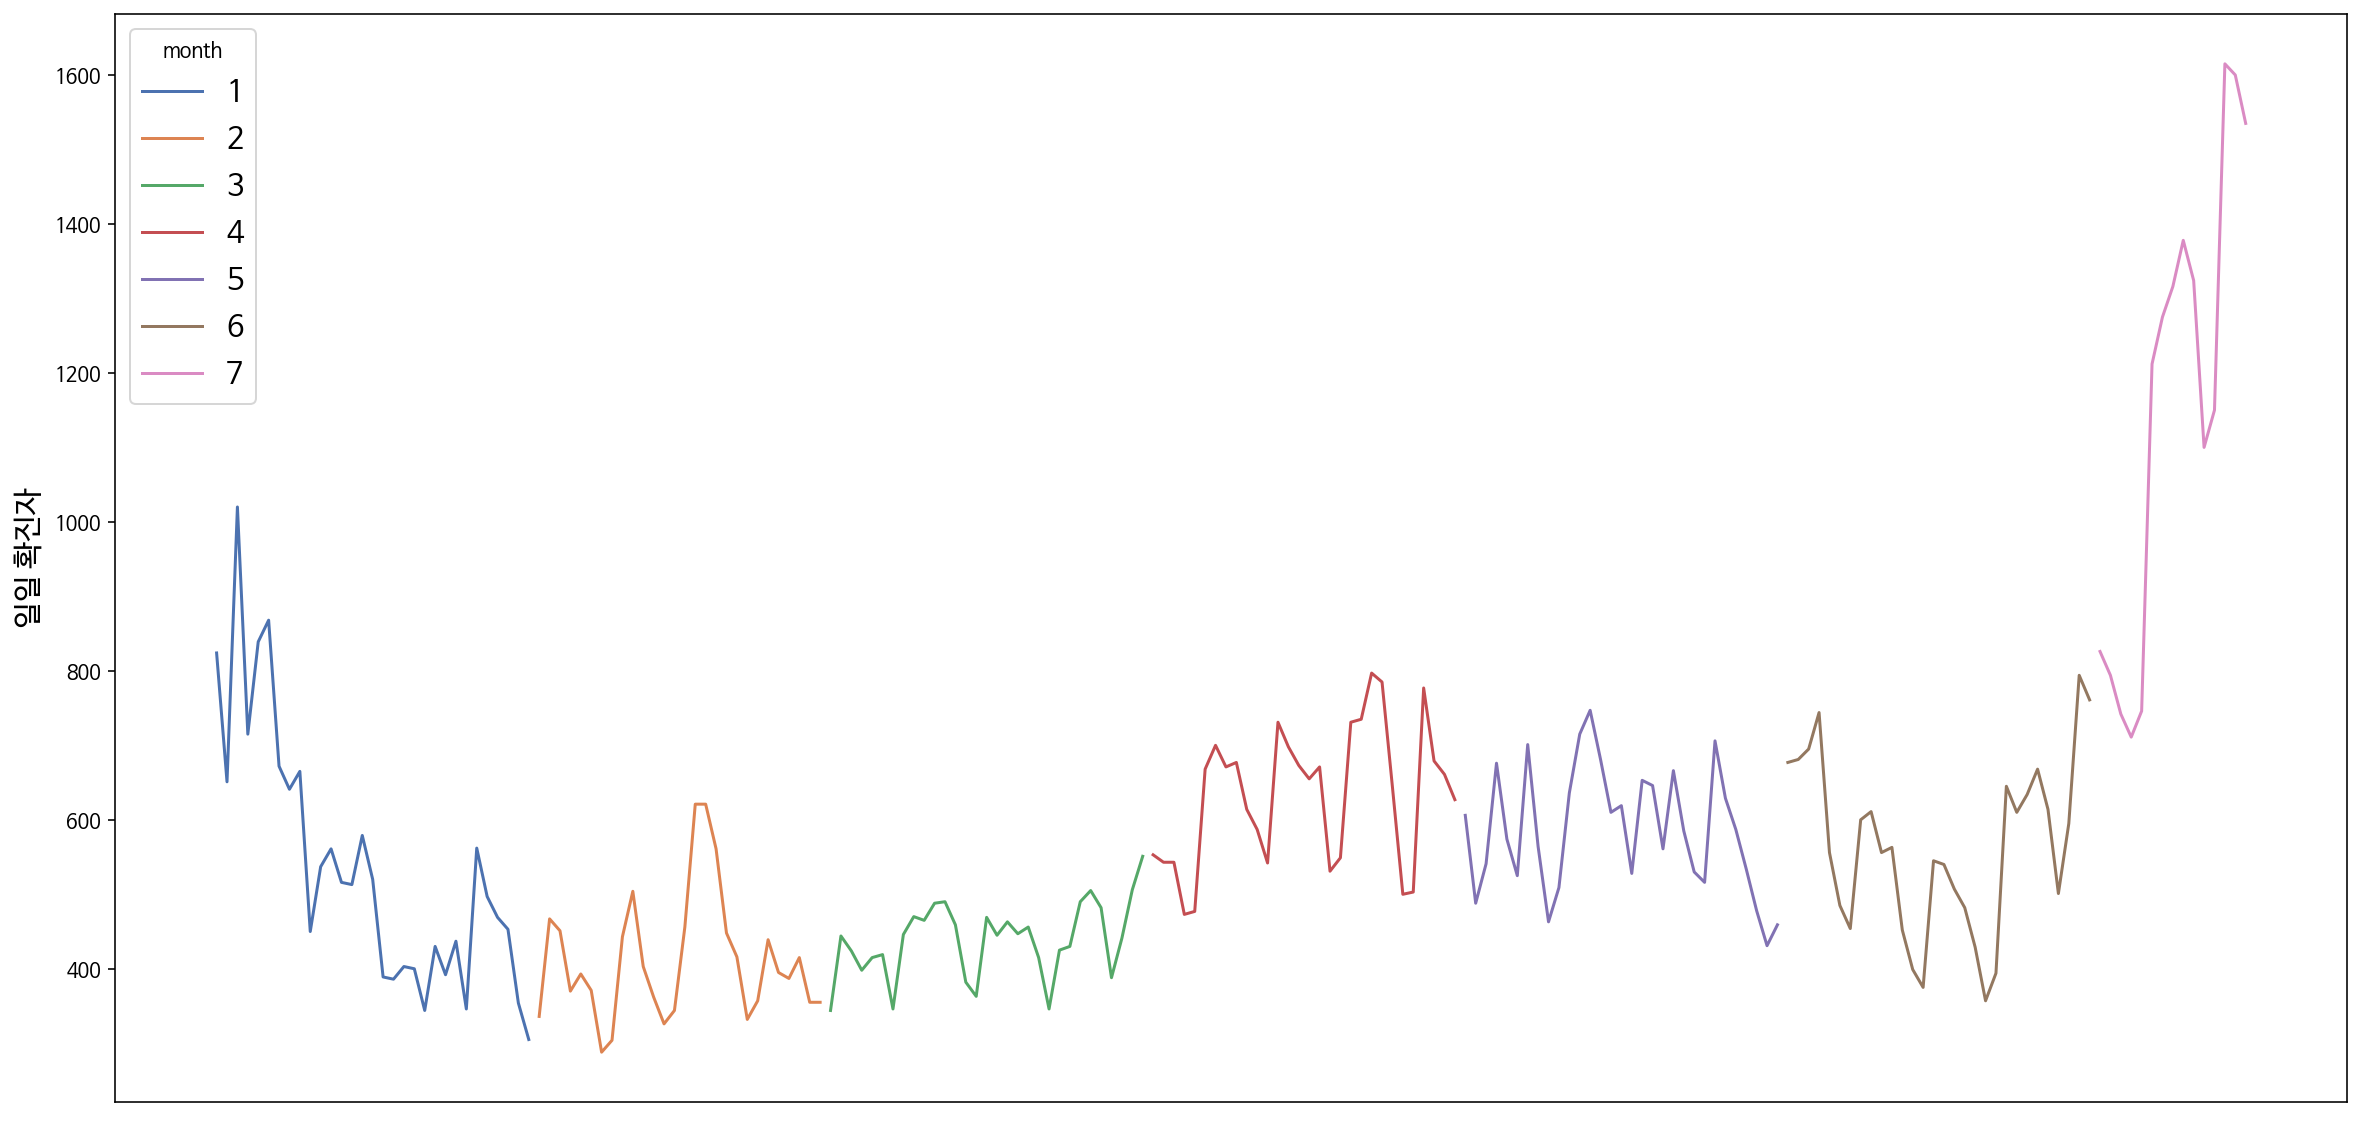

In [206]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
p=sns.set_palette("deep")
p=sns.lineplot(data=final_forday,x='월',y='일일확진자',hue=final_forday['월'].str[1:2])
p.set_ylabel("일일 확진자", fontsize = 15)
plt.legend(loc='upper left',title='month',prop={'size': 15})

plt.show()

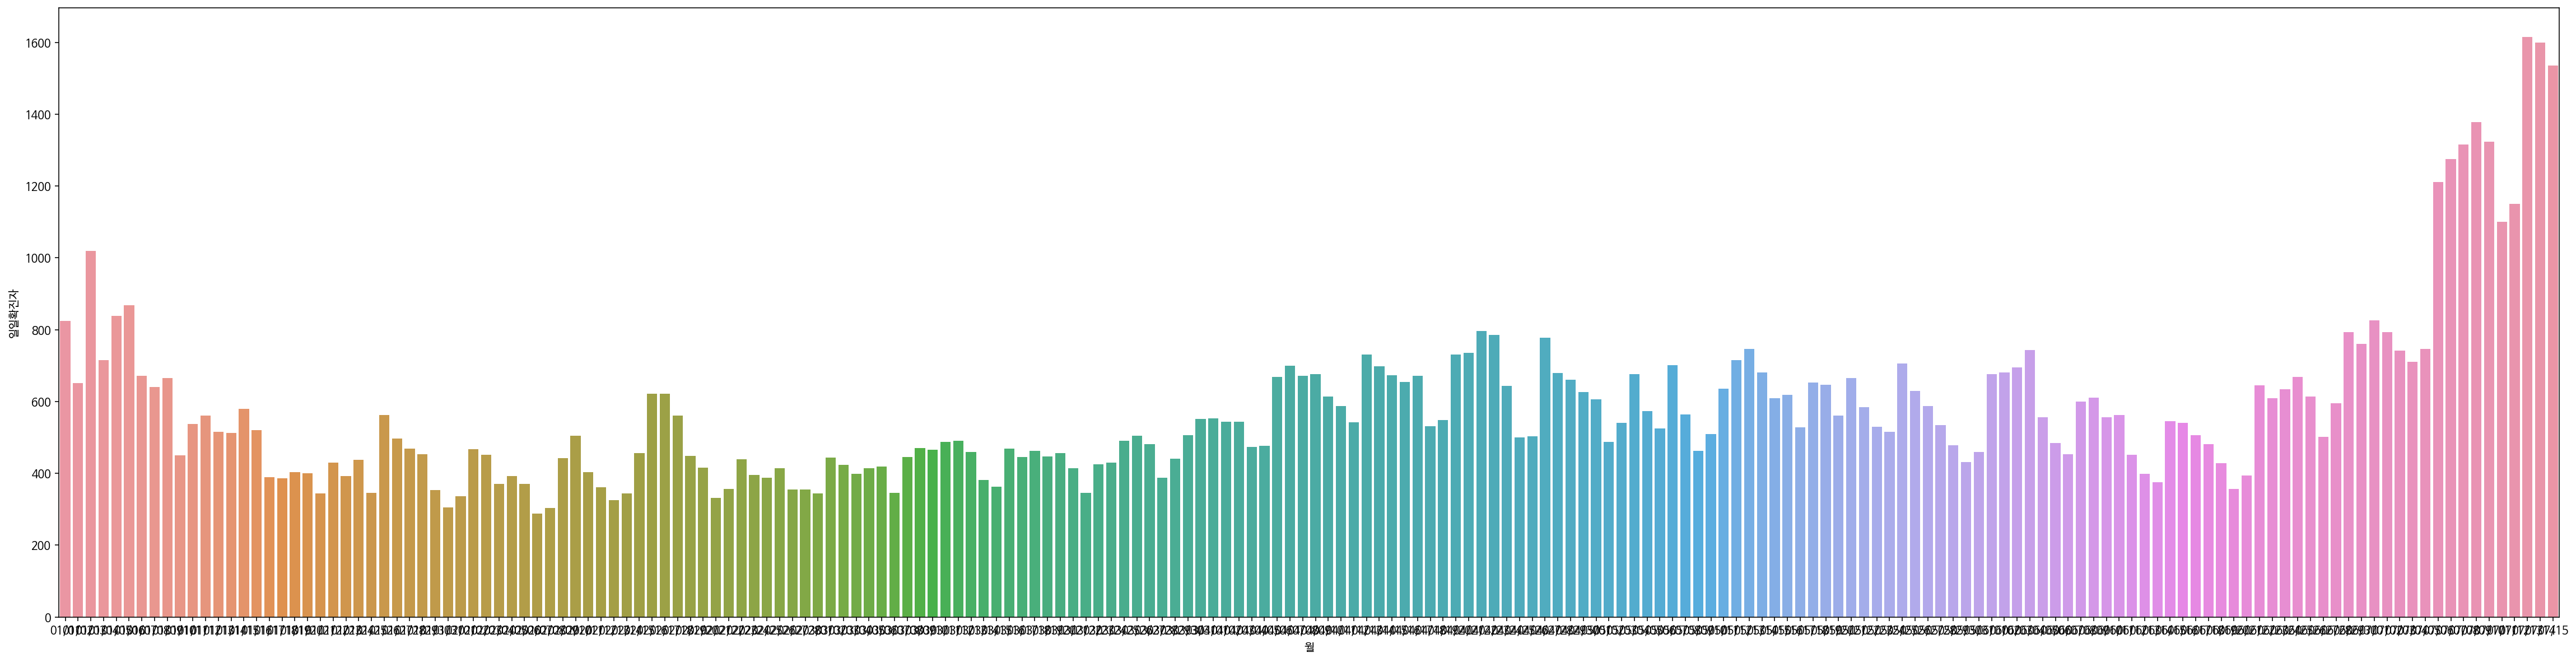

In [163]:
plt.figure(figsize=(40,10))
sns.barplot(data=final_forday,x='월',y='일일확진자')

신규+누적확진자

In [164]:
#1월 확진자
sum(df[:9]['realreal'])

824.0

In [166]:
61769-824

60945

In [167]:
foraccumulate['since2021']=foraccumulate['confcase']-60945

In [168]:
foraccumulate

,createdt,confcase,since2021
0,2021-01-01,61769,824
1,2021-01-02,62593,1648
2,2021-01-03,63244,2299
3,2021-01-04,64264,3319
4,2021-01-05,64979,4034
...,...,...,...
191,2021-07-11,168046,107101
192,2021-07-12,169146,108201
193,2021-07-13,170296,109351
194,2021-07-14,171911,110966


## 2021년 신규 및 누적 확진자 현황(~7/15)

In [247]:
foraccumulate['createdt']=foraccumulate['createdt'].str[5:].str.replace('-','/')

No handles with labels found to put in legend.


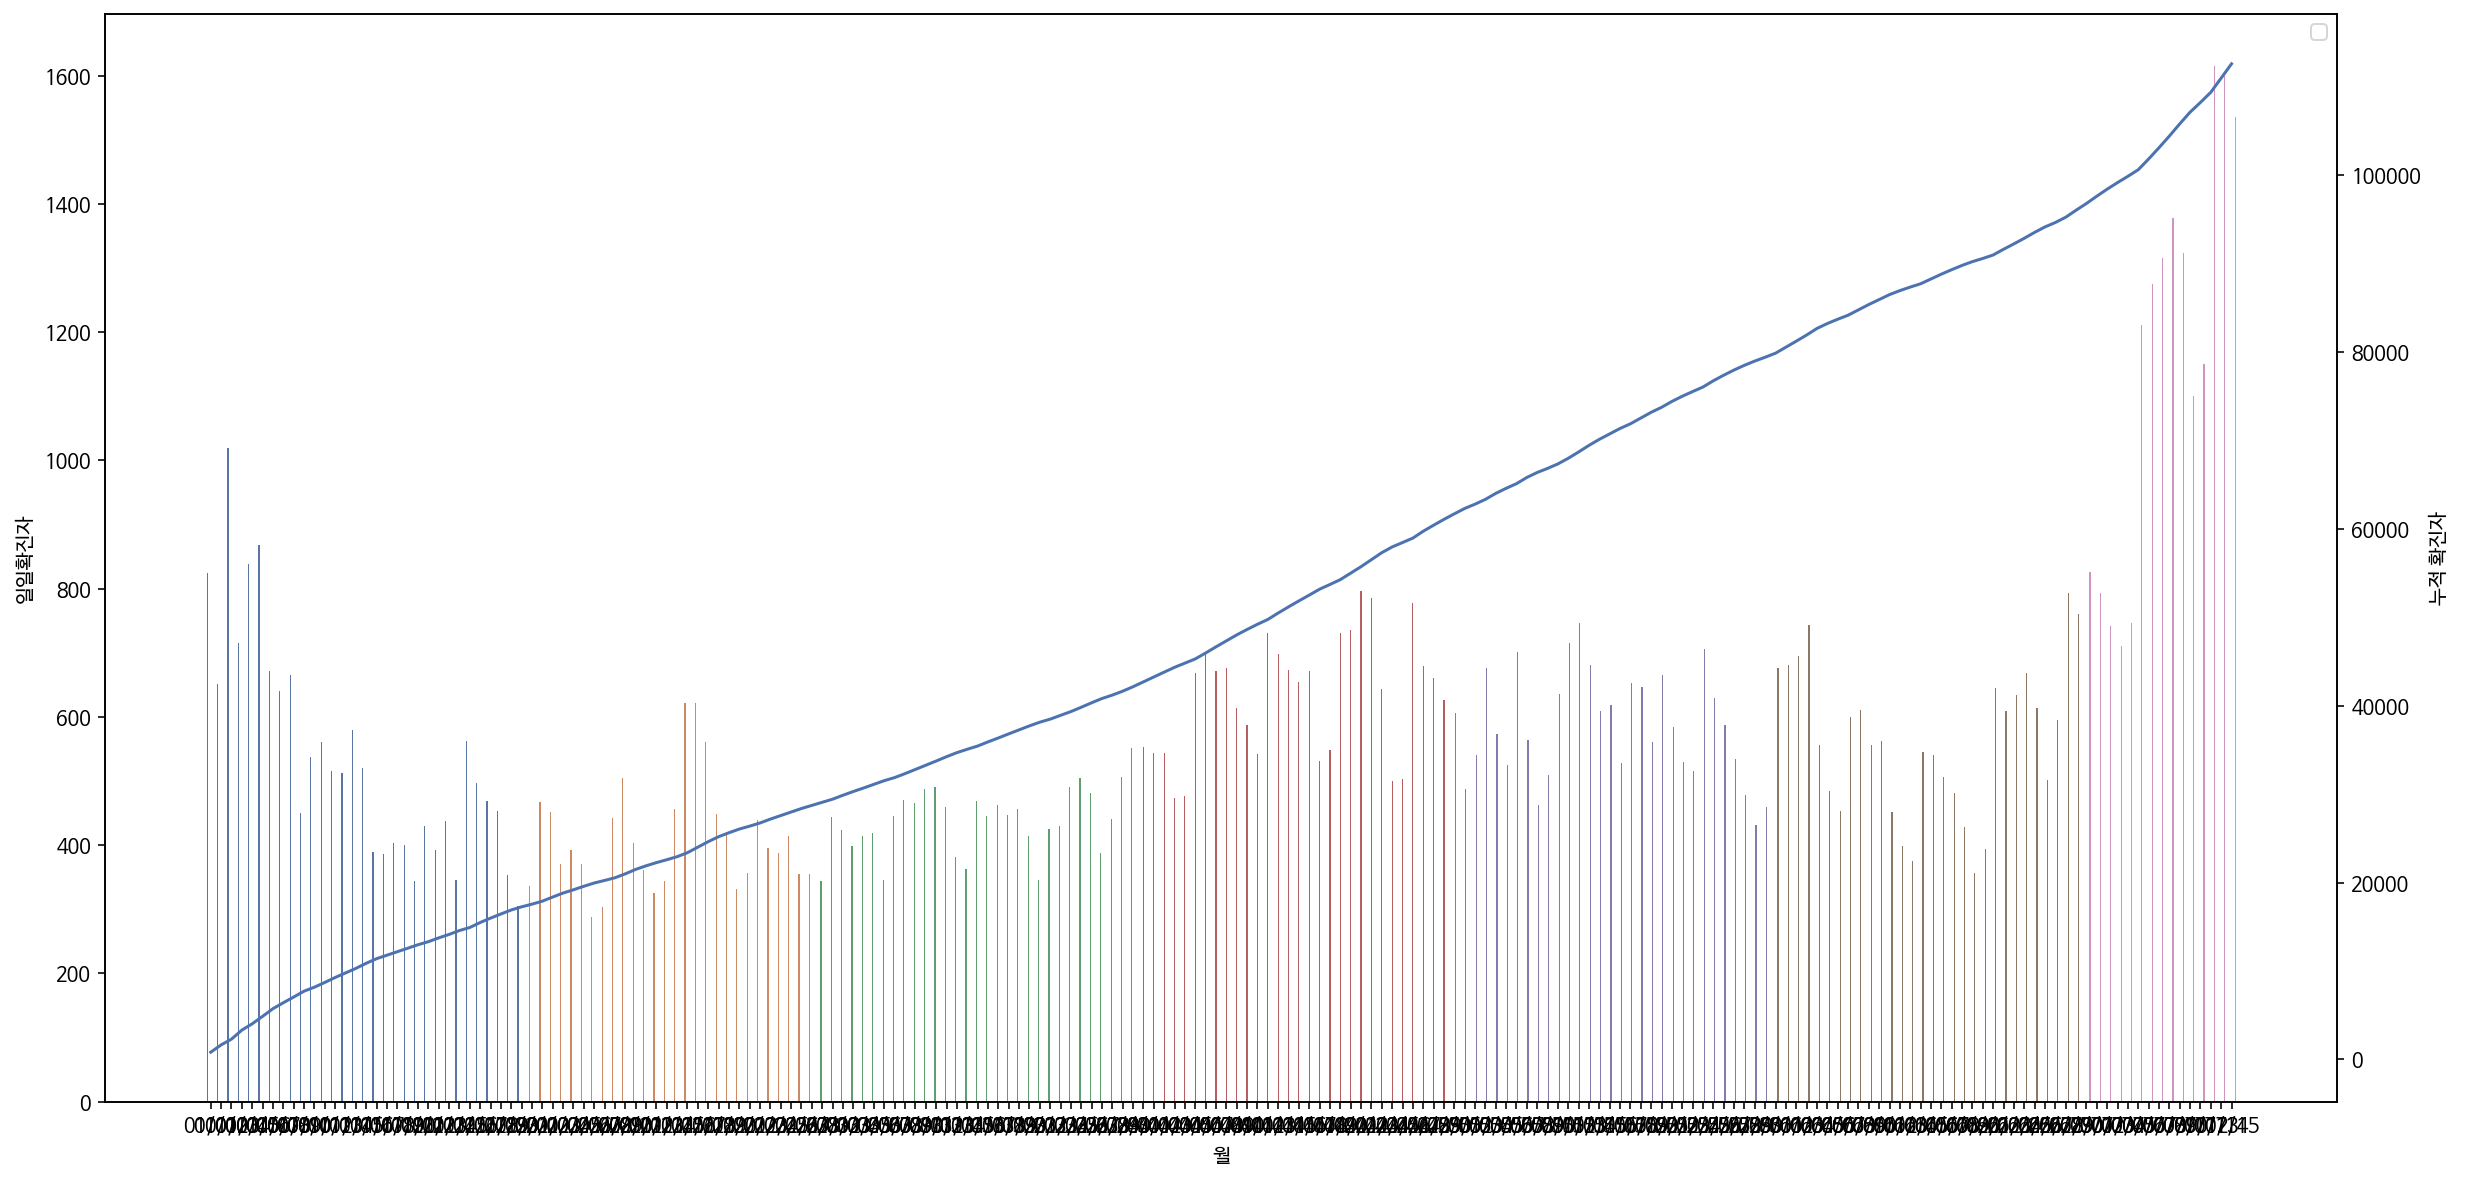

In [285]:
import matplotlib.pyplot as plt

fig,ax0=plt.subplots(figsize=(20,10))
ax1=ax0.twinx()

p=sns.set_palette("deep")
p=sns.barplot(data=final_forday,x='월',y='일일확진자',hue=final_forday['월'].str[1:2],ax=ax0)
p=sns.lineplot(data=foraccumulate,x='createdt',y='since2021',ax=ax1)

leg = plt.legend()
ax0.get_legend().remove()

p.set_ylabel("누적 확진자", fontsize = 10)

plt.show()

### [시각화] 연령대 별 확진자(날짜 기준2개)


In [171]:
df

,confcase,createdt,gubun,realreal
0,2132,2021-01-01,a.0-9,39.0
1,3844,2021-01-01,b.10-19,66.0
2,9836,2021-01-01,c.20-29,111.0
3,7873,2021-01-01,d.30-39,109.0
4,8778,2021-01-01,e.40-49,106.0
...,...,...,...,...
1759,27241,2021-07-15,e.40-49,268.0
1760,31483,2021-07-15,f.50-59,242.0
1761,23965,2021-07-15,g.60-69,109.0
1762,10561,2021-07-15,h.70-79,14.0


In [184]:
#7/1
period1=df[(df['createdt']>'2021-06-31') ]
period2=df[(df['createdt']<='2021-06-30') & (df['createdt']>='2021-06-16') ]

In [185]:
period1=pd.DataFrame(period1.groupby(['gubun']).sum()['realreal'])
period1=period1.reset_index()
period1=period1.rename(columns={'realreal':'daily'})
period1['period']='7/1~7/15'
period1

,gubun,daily,period
0,a.0-9,888.0,7/1~7/15
1,b.10-19,1727.0,7/1~7/15
2,c.20-29,4332.0,7/1~7/15
3,d.30-39,3081.0,7/1~7/15
4,e.40-49,3146.0,7/1~7/15
5,f.50-59,2851.0,7/1~7/15
6,g.60-69,954.0,7/1~7/15
7,h.70-79,239.0,7/1~7/15
8,i.80 이상,106.0,7/1~7/15


In [186]:
period2=pd.DataFrame(period2.groupby(['gubun']).sum()['realreal'])
period2=period2.reset_index()
period2=period2.rename(columns={'realreal':'daily'})
period2['period']='6/16~6/30'
period2.head()

,gubun,daily,period
0,a.0-9,511.0,6/16~6/30
1,b.10-19,742.0,6/16~6/30
2,c.20-29,1713.0,6/16~6/30
3,d.30-39,1465.0,6/16~6/30
4,e.40-49,1557.0,6/16~6/30


In [187]:
insight_1=pd.concat([period1,period2])
insight_1.head()

,gubun,daily,period
0,a.0-9,888.0,7/1~7/15
1,b.10-19,1727.0,7/1~7/15
2,c.20-29,4332.0,7/1~7/15
3,d.30-39,3081.0,7/1~7/15
4,e.40-49,3146.0,7/1~7/15


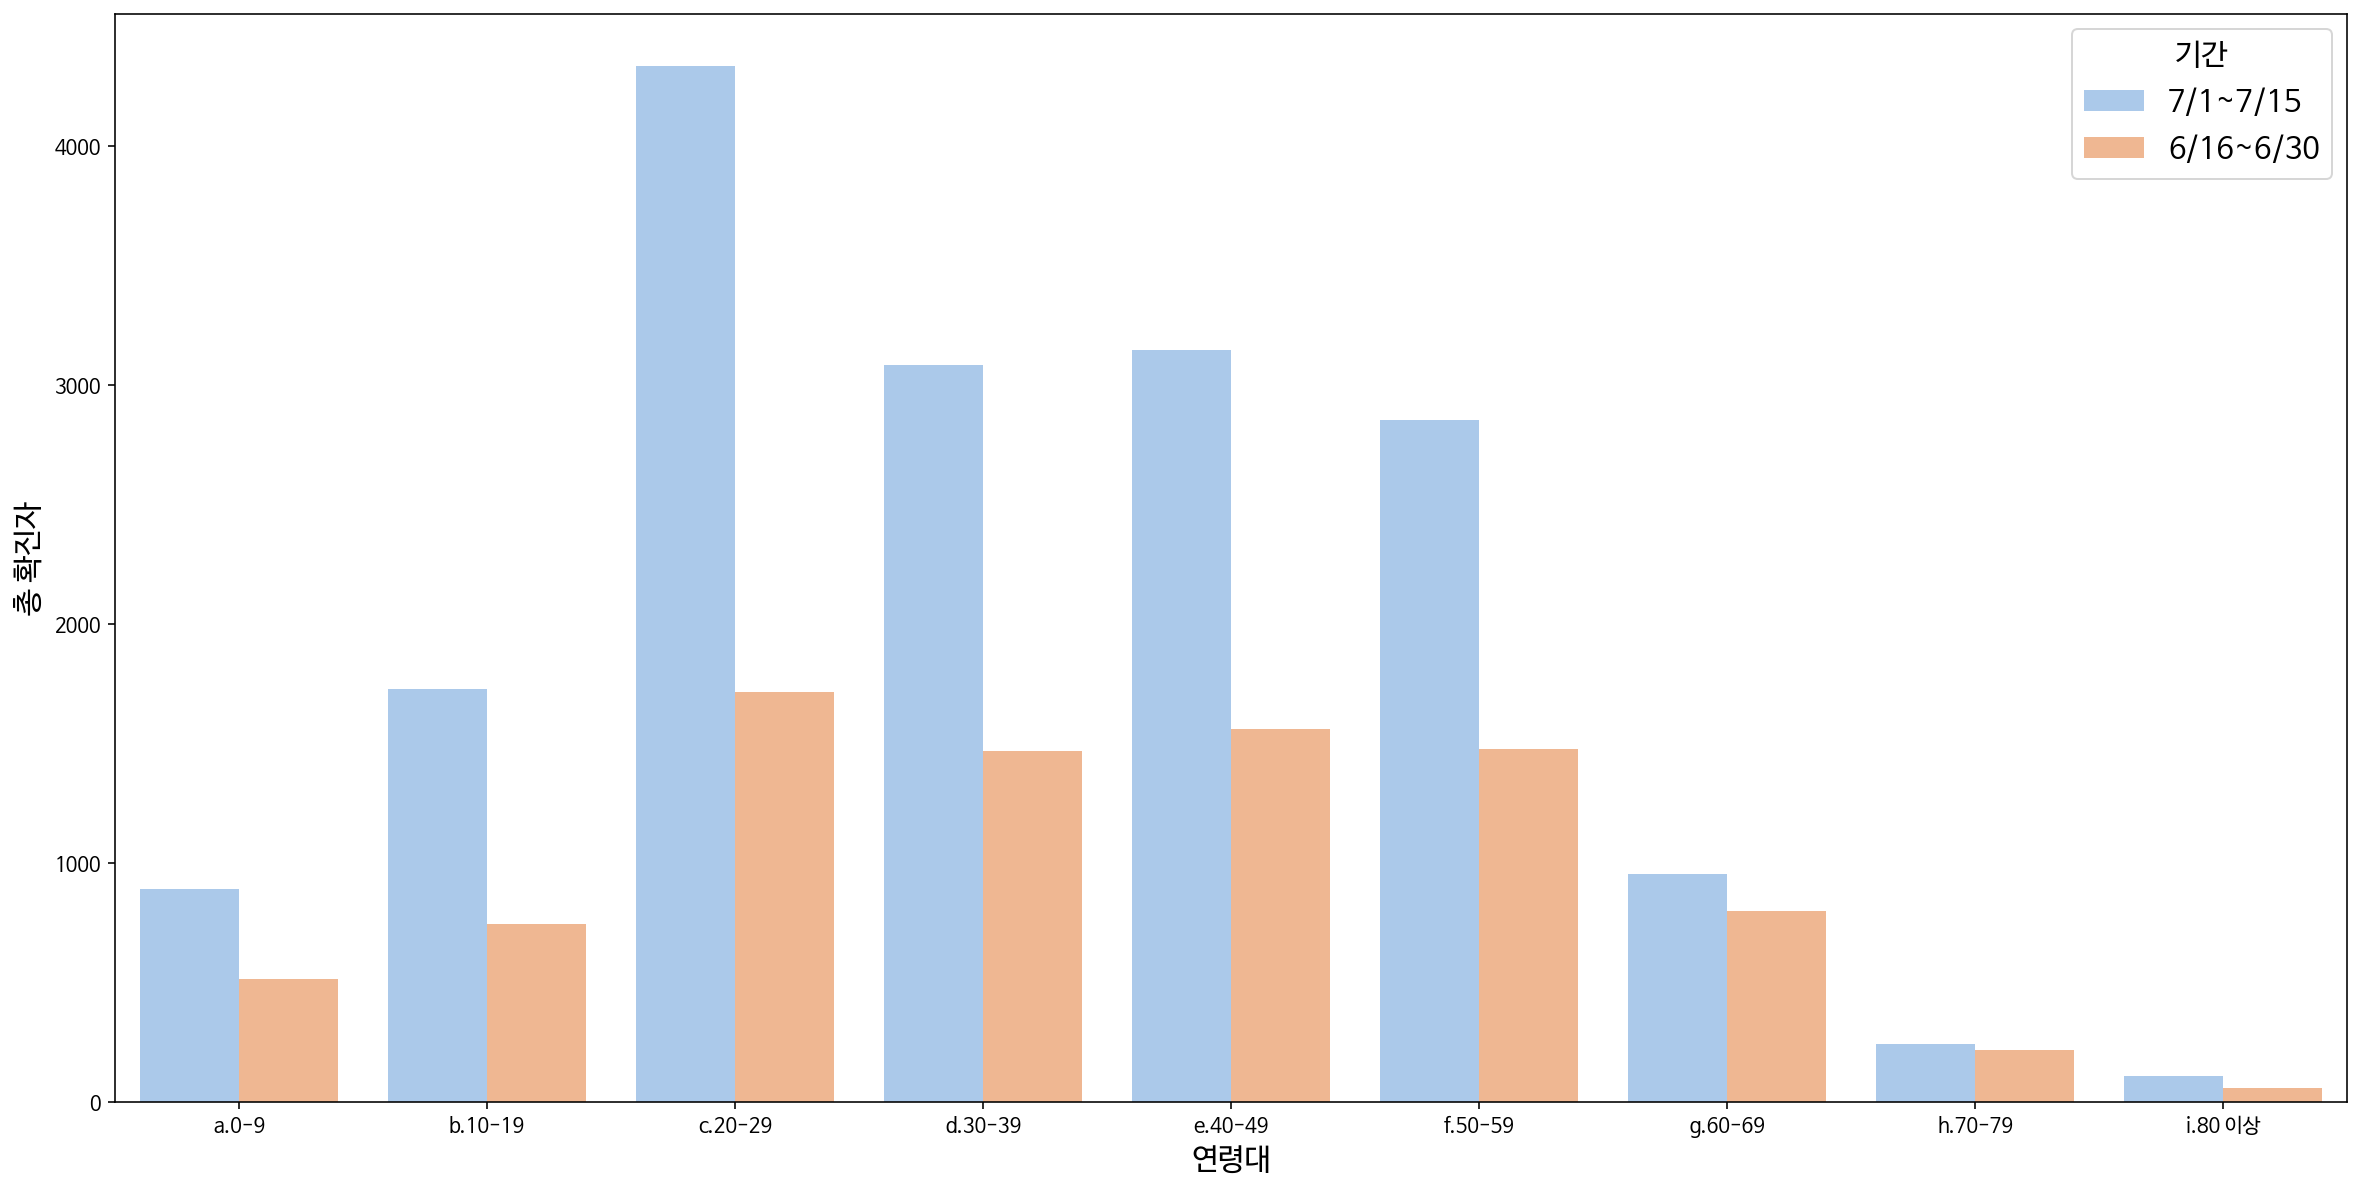

In [196]:
plt.figure(figsize=(20,10))
p=sns.set_palette("pastel")
p=sns.barplot(x='gubun', y='daily',hue='period', data=insight_1); # default : dodge=True
p.set_xlabel("연령대", fontsize = 15)
p.set_ylabel("총 확진자", fontsize = 15)

plt.legend(title='기간',title_fontsize=15,prop={'size': 15})

### 2. 지역별 발생현황

In [207]:
import requests 
import pandas as pd 
from bs4 import BeautifulSoup 
from datetime import date, datetime 

def getCovid19Info_2(start_date: date, end_date: date): 
  url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson" 
  api_key_utf8 = "zMLNeBeTjLWViEmY%2BV3xqMuqCJVhZ0%2Fv5%2FESR5vFzH%2FQoRNdsotDqTRLcx2Qg10OoS6MseNTQxuIEfKb5lVo1Q%3D%3D" 
  api_key_decode = requests.utils.unquote(api_key_utf8, encoding='utf-8')
  
  params={ "ServiceKey": api_key_decode, 
          "startCreateDt": int('{:04d}{:02d}{:02d}'.format(start_date.year, start_date.month, start_date.day)), 
          "endCreateDt": int('{:04d}{:02d}{:02d}'.format(end_date.year, end_date.month, end_date.day)), 
          } 
          
  response = requests.get(url, params=params) 
  
  return BeautifulSoup(response.text, "lxml")

In [208]:
convert_method = { 
    'confcase':int,
    'confcaserate':float,
    'criticalrate':float,
    'deathrate':float,
    'seq':int,
    'gubun': str, 
    'death': int, 
    'createdt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'), #(x, '%Y-%m-%d %H:%M:%S.%f'), 
    'updatedt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') ,
    'gubun':str,
    'incdec':int, #전일대비 증감 수
    'defcnt':int, #DEF_CNT
    'localocccnt':int, #지역발생 수
    'deathcnt':int, #사망자 수
    'isolclearcnt':int,
    'isolingcnt':int,
    'overflowcnt':int,
    'qurrate':float,
    'stdday':str
    }

In [209]:
temp = getCovid19Info_2(date(2021,1,1), date(2021, 7, 16)) 
items = temp.find('items') 
df_2=parsing(items)

In [210]:
df_2

,createdt,deathcnt,defcnt,gubun,gubuncn,gubunen,incdec,isolclearcnt,isolingcnt,localocccnt,overflowcnt,qurrate,seq,stdday,updatedt
0,2021-07-16 09:42:39.007,5,4655,검역,None,None,34,4243,407,0,34,NaN,10780,2021년 07월 16일 00시,None
1,2021-07-16 09:42:39.007,1,1452,제주,None,None,10,1281,170,9,1,215.23,10779,2021년 07월 16일 00시,None
2,2021-07-16 09:42:39.007,22,5829,경남,None,None,80,5282,525,79,1,174.51,10778,2021년 07월 16일 00시,None
3,2021-07-16 09:42:39.007,87,5110,경북,None,None,12,4885,138,10,2,193.60,10777,2021년 07월 16일 00시,None
4,2021-07-16 09:42:39.007,17,1778,전남,None,None,8,1634,127,7,1,96.03,10776,2021년 07월 16일 00시,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738,2021-01-01 09:41:33.330,29,2904,인천,None,None,65,2150,725,63,2,35.93,6757,2021년 01월 01일 00시,None
3739,2021-01-01 09:41:33.330,201,7844,대구,None,None,43,7294,349,43,0,294.85,6756,2021년 01월 01일 00시,None
3740,2021-01-01 09:41:33.330,50,1925,부산,None,None,57,1370,505,55,2,17.59,6755,2021년 01월 01일 00시,None
3741,2021-01-01 09:41:33.330,182,19362,서울,None,None,358,10787,8393,357,1,64.44,6754,2021년 01월 01일 00시,None


In [211]:
import datetime
df_2['createdt']=df_2['createdt']- datetime.timedelta(days=1)

In [212]:
df_2

,createdt,deathcnt,defcnt,gubun,gubuncn,gubunen,incdec,isolclearcnt,isolingcnt,localocccnt,overflowcnt,qurrate,seq,stdday,updatedt
0,2021-07-15 09:42:39.007,5,4655,검역,None,None,34,4243,407,0,34,NaN,10780,2021년 07월 16일 00시,None
1,2021-07-15 09:42:39.007,1,1452,제주,None,None,10,1281,170,9,1,215.23,10779,2021년 07월 16일 00시,None
2,2021-07-15 09:42:39.007,22,5829,경남,None,None,80,5282,525,79,1,174.51,10778,2021년 07월 16일 00시,None
3,2021-07-15 09:42:39.007,87,5110,경북,None,None,12,4885,138,10,2,193.60,10777,2021년 07월 16일 00시,None
4,2021-07-15 09:42:39.007,17,1778,전남,None,None,8,1634,127,7,1,96.03,10776,2021년 07월 16일 00시,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738,2020-12-31 09:41:33.330,29,2904,인천,None,None,65,2150,725,63,2,35.93,6757,2021년 01월 01일 00시,None
3739,2020-12-31 09:41:33.330,201,7844,대구,None,None,43,7294,349,43,0,294.85,6756,2021년 01월 01일 00시,None
3740,2020-12-31 09:41:33.330,50,1925,부산,None,None,57,1370,505,55,2,17.59,6755,2021년 01월 01일 00시,None
3741,2020-12-31 09:41:33.330,182,19362,서울,None,None,358,10787,8393,357,1,64.44,6754,2021년 01월 01일 00시,None


In [213]:
from datetime import date, datetime 
df_2=df_2[['createdt','deathcnt','defcnt','gubun','incdec']]
df_2['createdt']=df_2['createdt'].dt.strftime('%Y-%m-%d')
df_2

,createdt,deathcnt,defcnt,gubun,incdec
0,2021-07-15,5,4655,검역,34
1,2021-07-15,1,1452,제주,10
2,2021-07-15,22,5829,경남,80
3,2021-07-15,87,5110,경북,12
4,2021-07-15,17,1778,전남,8
...,...,...,...,...,...
3738,2020-12-31,29,2904,인천,65
3739,2020-12-31,201,7844,대구,43
3740,2020-12-31,50,1925,부산,57
3741,2020-12-31,182,19362,서울,358


In [214]:
df_2=df_2[df_2['createdt']>='2021-01-01']

모든 날짜에 19개의 지역별로 데이터가 잘 있는지 확인

In [215]:
check19=pd.DataFrame(df_2.groupby('createdt').count()['gubun'])
check19=check19.reset_index()

In [216]:
check19[check19['gubun']!=19]

,createdt,gubun


In [217]:
df_2.isnull().sum()

createdt    0
deathcnt    0
defcnt      0
gubun       0
incdec      0
dtype: int64

In [218]:
df_2[df_2['gubun']=='합계'].head()

,createdt,deathcnt,defcnt,gubun,incdec
18,2021-07-15,2051,175046,합계,1536
37,2021-07-14,2050,173511,합계,1600
56,2021-07-13,2048,171911,합계,1615
75,2021-07-12,2046,170296,합계,1150
94,2021-07-11,2044,169146,합계,1100


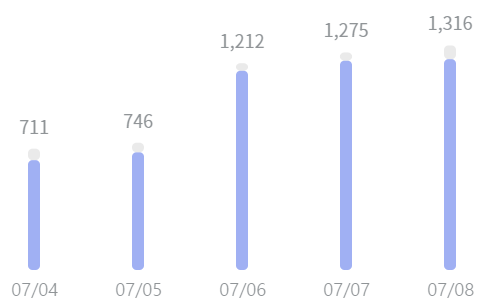

실제 '코로나 라이브'에서 확인할 수 있는 확진자의 수와 일치  
[이미지 출처](https://corona-live.com/)

In [219]:
seoul=df_2[df_2['gubun']=='서울']

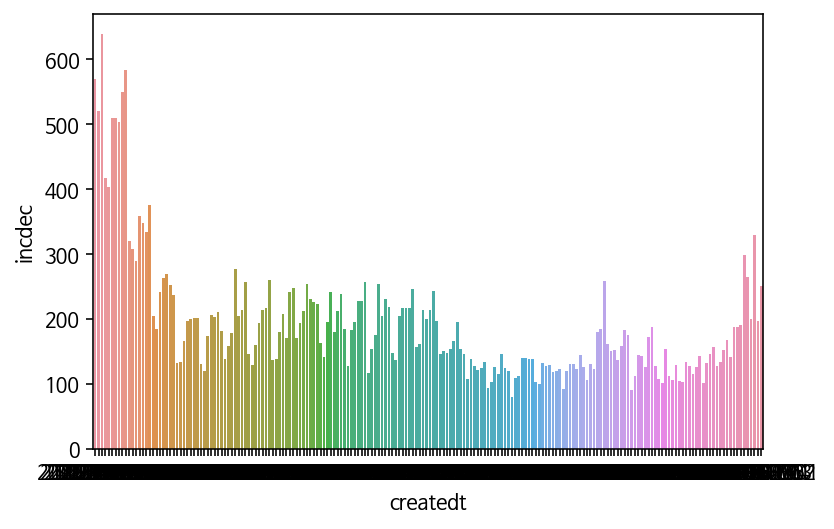

In [220]:
import seaborn as sns
sns.barplot(x=seoul['createdt'],y=seoul['incdec'])

### [시각화]서울 한달 간 신규 및 누적 확진자

In [222]:
insight1=seoul[seoul['createdt']>'2021-06-15']
insight1

,createdt,deathcnt,defcnt,gubun,incdec
17,2021-07-15,525,57142,서울,570
36,2021-07-14,525,56573,서울,520
55,2021-07-13,524,56053,서울,638
74,2021-07-12,523,55415,서울,417
93,2021-07-11,523,54998,서울,403
112,2021-07-10,523,54595,서울,509
131,2021-07-09,521,54086,서울,509
150,2021-07-08,519,53577,서울,503
169,2021-07-07,518,53074,서울,550
188,2021-07-06,518,52524,서울,583


In [223]:
47133-201

46932

In [224]:
insight1['for1month']=insight1['defcnt']-46932
insight1

,createdt,deathcnt,defcnt,gubun,incdec,for1month
17,2021-07-15,525,57142,서울,570,10210
36,2021-07-14,525,56573,서울,520,9641
55,2021-07-13,524,56053,서울,638,9121
74,2021-07-12,523,55415,서울,417,8483
93,2021-07-11,523,54998,서울,403,8066
112,2021-07-10,523,54595,서울,509,7663
131,2021-07-09,521,54086,서울,509,7154
150,2021-07-08,519,53577,서울,503,6645
169,2021-07-07,518,53074,서울,550,6142
188,2021-07-06,518,52524,서울,583,5592


In [225]:
insight1=insight1.sort_values(by=['createdt'],axis=0)

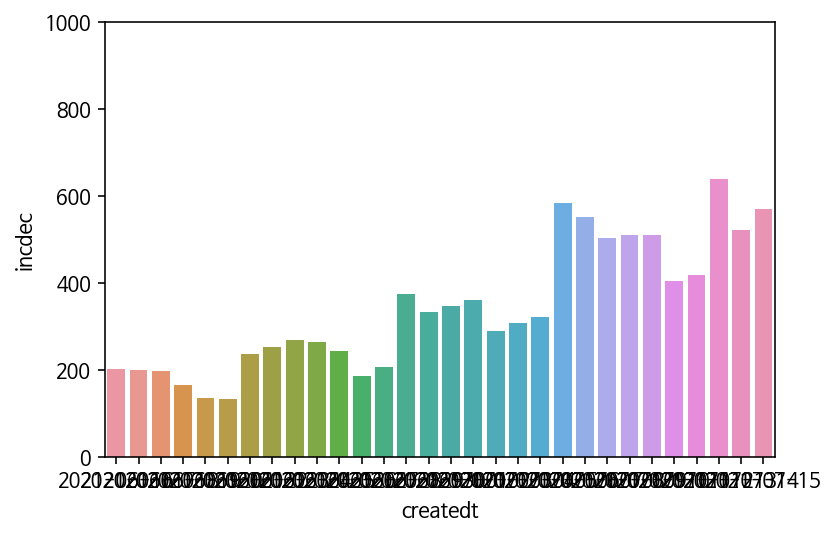

In [227]:
plt.ylim(0, 1000)
sns.barplot(x=insight1['createdt'],y=insight1['incdec'])

In [228]:
insight1=insight1.rename(columns={'createdt':'날짜','incdec':'일일확진자','for1month':'누적확진자'})

In [229]:
insight1['날짜']=insight1['날짜'].str[5:].str.replace('-','/')

In [230]:
insight1

,날짜,deathcnt,defcnt,gubun,일일확진자,누적확진자
568,06/16,504,47133,서울,201,201
549,06/17,505,47333,서울,200,401
530,06/18,506,47530,서울,197,598
511,06/19,507,47695,서울,165,763
492,06/20,508,47829,서울,134,897
473,06/21,509,47960,서울,132,1028
454,06/22,510,48196,서울,236,1264
435,06/23,510,48448,서울,252,1516
416,06/24,511,48717,서울,269,1785
397,06/25,512,48980,서울,263,2048


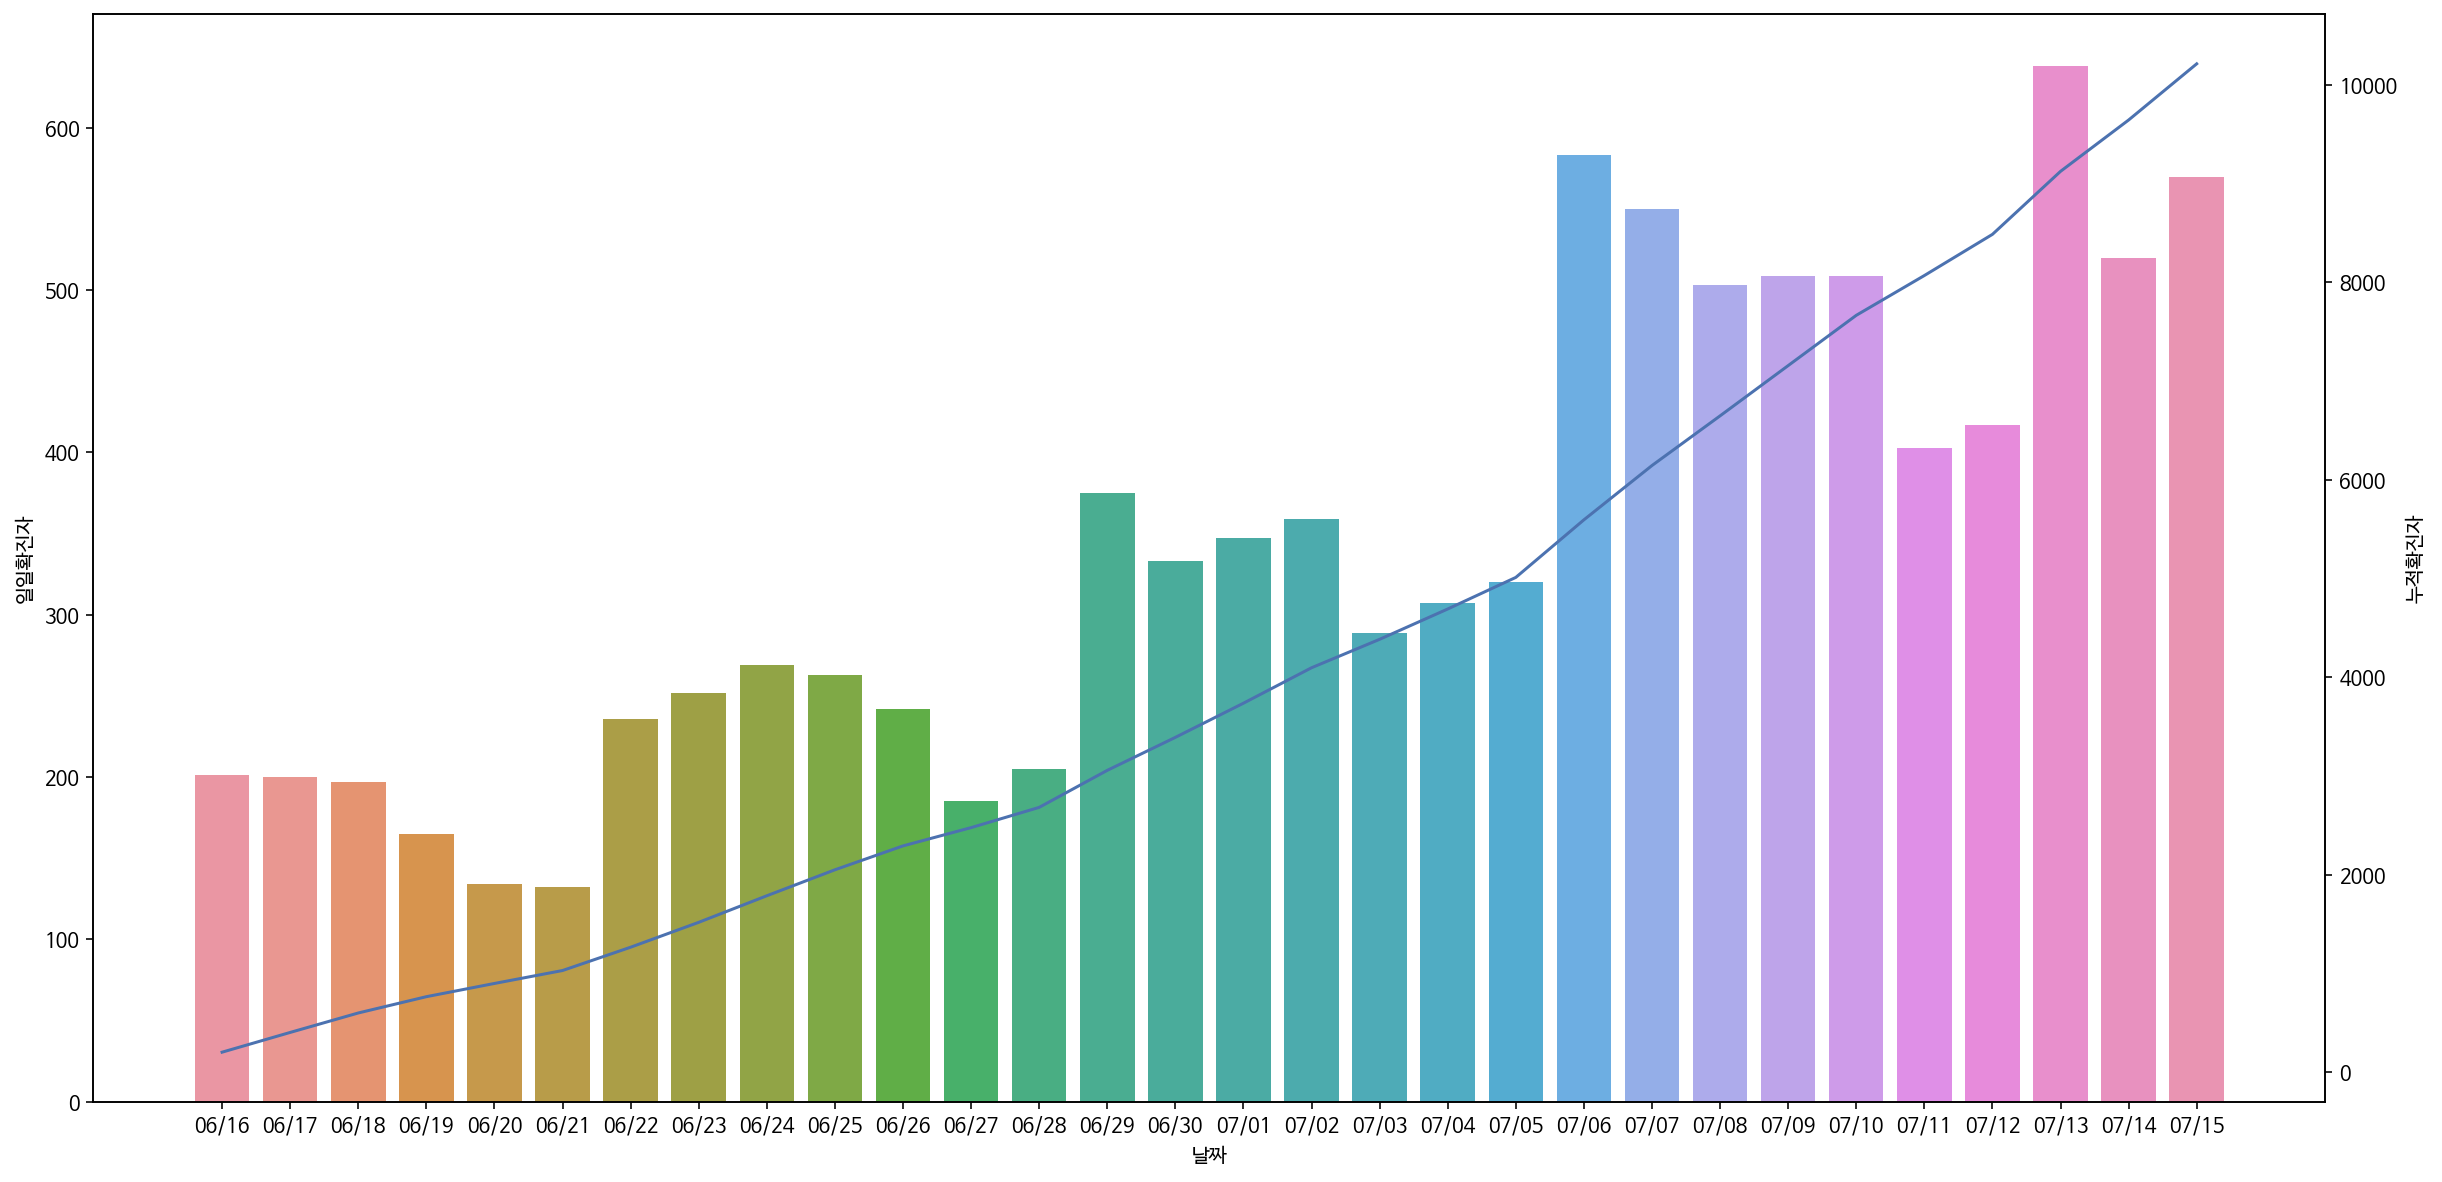

In [231]:
fig,ax0=plt.subplots(figsize=(20,10))
ax1=ax0.twinx()

sns.barplot(x=insight1['날짜'],y=insight1['일일확진자'],ax=ax0)
sns.lineplot(x=insight1['날짜'],y=insight1['누적확진자'],ax=ax1)


In [232]:
insight2=df_2[(df_2['createdt']>'2021-06-07') & (df_2['gubun']=='합계')]
insight2

,createdt,deathcnt,defcnt,gubun,incdec
18,2021-07-15,2051,175046,합계,1536
37,2021-07-14,2050,173511,합계,1600
56,2021-07-13,2048,171911,합계,1615
75,2021-07-12,2046,170296,합계,1150
94,2021-07-11,2044,169146,합계,1100
113,2021-07-10,2043,168046,합계,1324
132,2021-07-09,2038,166722,합계,1378
151,2021-07-08,2036,165344,합계,1316
170,2021-07-07,2034,164028,합계,1275
189,2021-07-06,2033,162753,합계,1212


In [ ]:
145690-600

145090

In [ ]:
insight2['for1month']=insight2['defcnt']-145090
insight2

,createdt,deathcnt,defcnt,gubun,incdec,for1month
18,2021-07-08,2036,165344,합계,1316,20254
37,2021-07-07,2034,164028,합계,1275,18938
56,2021-07-06,2033,162753,합계,1212,17663
75,2021-07-05,2032,161541,합계,746,16451
94,2021-07-04,2028,160795,합계,711,15705
113,2021-07-03,2026,160084,합계,743,14994
132,2021-07-02,2025,159342,합계,794,14252
151,2021-07-01,2024,158548,합계,826,13458
170,2021-06-30,2021,157723,합계,761,12633
189,2021-06-29,2018,156961,합계,794,11871


In [ ]:
insight2=insight2.sort_values(by=['createdt'],axis=0)

In [ ]:
insight2=insight2.rename(columns={"createdt": "날짜","incdec":"일일확진자","for1month":"누적확진자"})

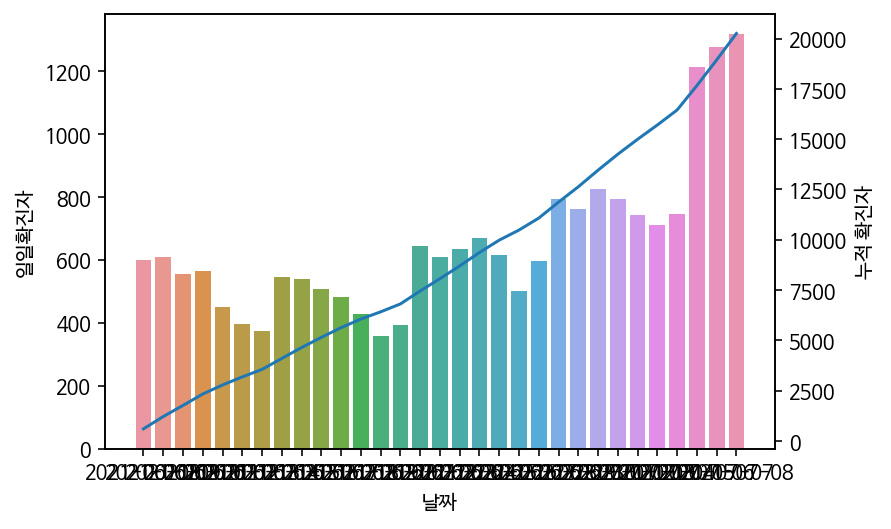

In [ ]:

fig,ax0=plt.subplots()
ax1=ax0.twinx()


plt.ylabel("누적 확진자")

sns.barplot(x=insight2['날짜'],y=insight2['일일확진자'],ax=ax0)
sns.lineplot(x=insight2['날짜'],y=insight2['누적확진자'],ax=ax1)
#

### [시각화]

In [233]:
seoul

,createdt,deathcnt,defcnt,gubun,incdec
17,2021-07-15,525,57142,서울,570
36,2021-07-14,525,56573,서울,520
55,2021-07-13,524,56053,서울,638
74,2021-07-12,523,55415,서울,417
93,2021-07-11,523,54998,서울,403
...,...,...,...,...,...
3646,2021-01-05,207,20602,서울,264
3665,2021-01-04,204,20338,서울,199
3684,2021-01-03,193,20138,서울,329
3703,2021-01-02,189,19809,서울,197


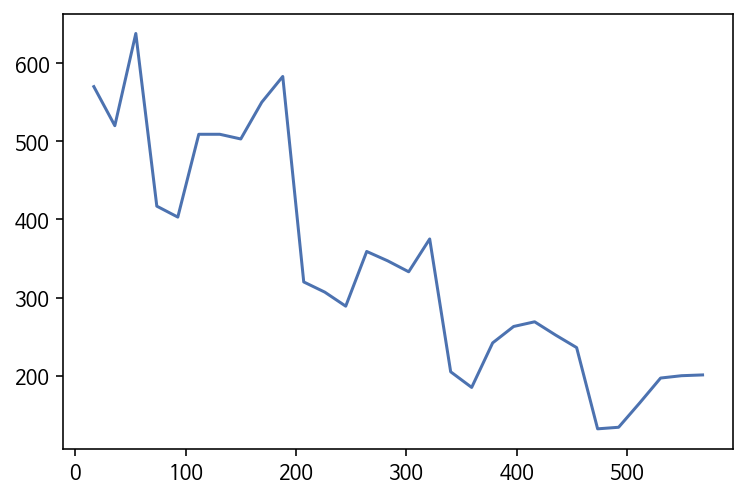

In [234]:
seoul[seoul['createdt']>='2021-06-16']['incdec'].plot()

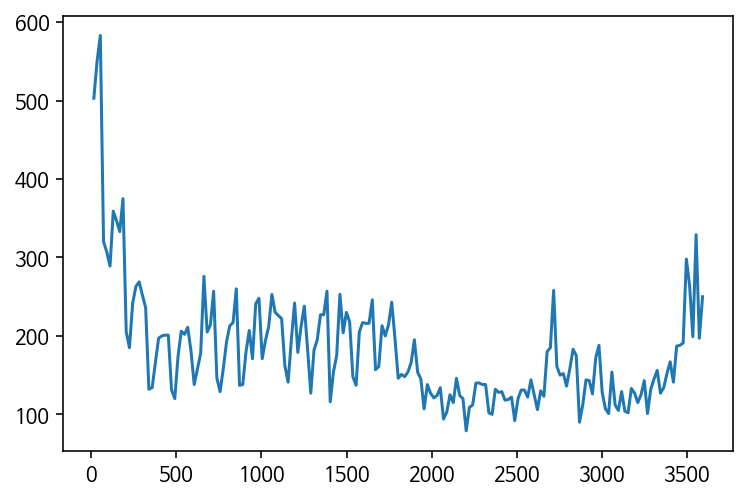

In [ ]:
seoul['incdec'].plot()

### 지역별 확진자

In [235]:
insight3=df_2.groupby(['gubun','createdt']).sum()
insight3=insight3.reset_index()
insight3=insight3[(insight3['gubun']!='합계')]
insight3

,gubun,createdt,deathcnt,defcnt,incdec
0,강원,2021-01-01,13,1268,31
1,강원,2021-01-02,15,1301,33
2,강원,2021-01-03,17,1329,28
3,강원,2021-01-04,17,1356,27
4,강원,2021-01-05,17,1372,16
...,...,...,...,...,...
3523,충북,2021-07-11,71,3398,14
3524,충북,2021-07-12,71,3406,8
3525,충북,2021-07-13,71,3416,10
3526,충북,2021-07-14,71,3428,12


In [237]:
insight33=insight3[insight3['createdt']>='2021-06-16'][['gubun','incdec','createdt']]
insight33=insight33.sort_values(by=['createdt'],axis=0)
insight33['createdt']=insight33['createdt'].str[5:].str.replace('-','/')

insight33

,gubun,incdec,createdt
166,강원,7,06/16
3302,충남,5,06/16
3106,제주,8,06/16
558,경기,183,06/16
2910,전북,7,06/16
...,...,...,...
2547,인천,97,07/15
2743,전남,8,07/15
2939,전북,13,07/15
1567,대전,49,07/15


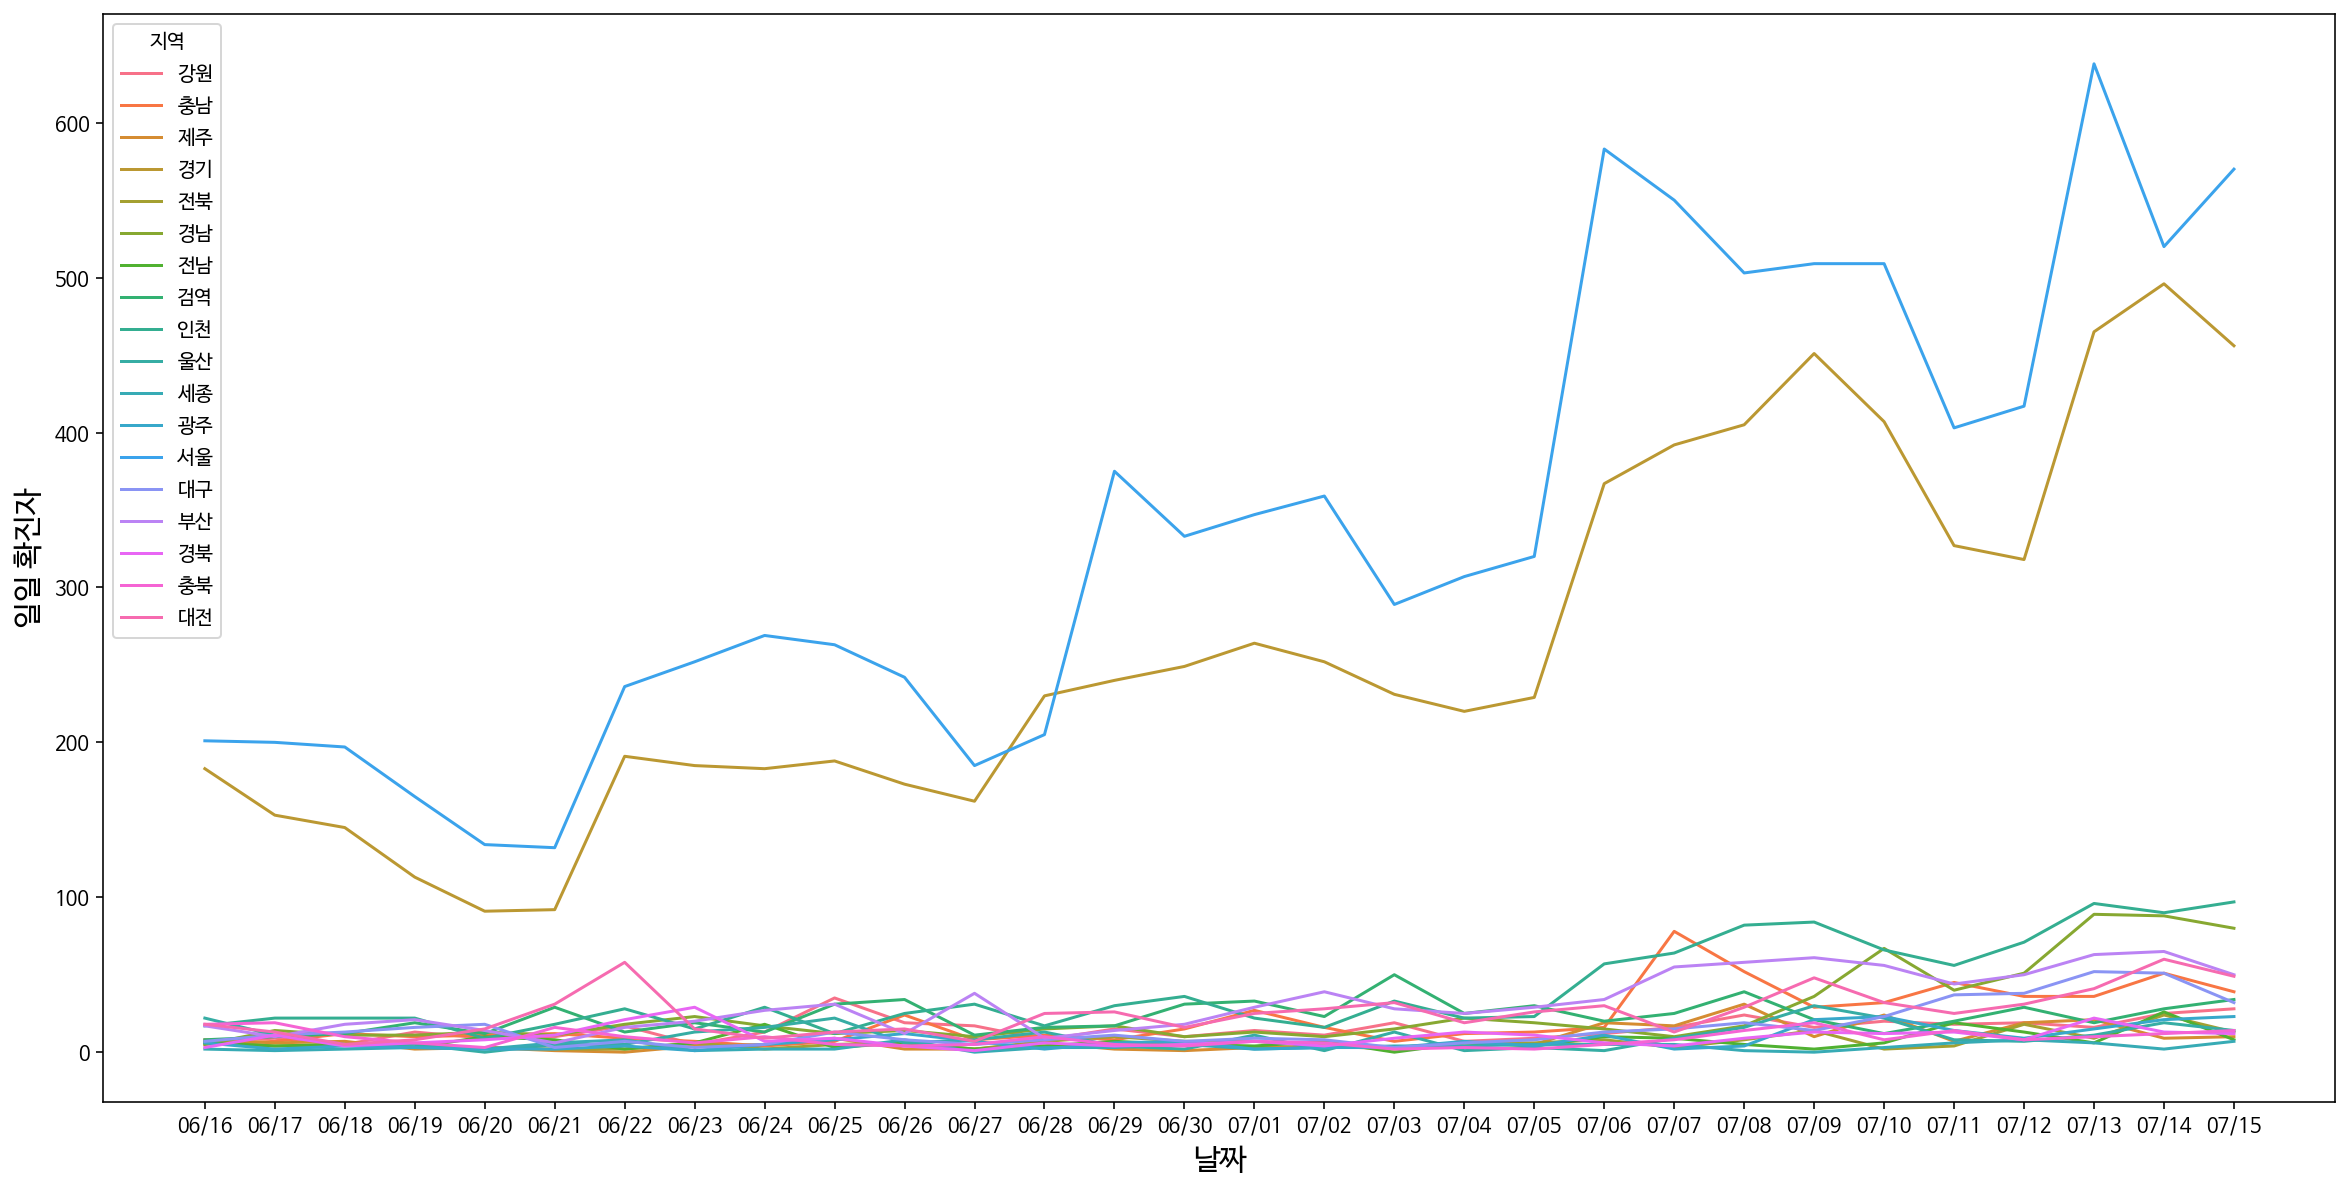

In [242]:
plt.figure(figsize=(20,10))
plt.xlabel("날짜")
plt.ylabel("일일 확진자")
p=sns.lineplot(x='createdt',y='incdec',hue='gubun',data=insight33)
p.set_xlabel("날짜", fontsize = 15)
p.set_ylabel("일일 확진자", fontsize = 15)
plt.legend(loc='upper left',title='지역',prop={'size': 10})